In [1]:
# plot data processing statistics
plot_data_process = True

# choose the Hyper-Parameters
# data Hyper-Parameters
num_features = 34 # maximum 34
scaler_name = 'minmax' # choose from ['standard','minmax']
train_batch_size = 32
eval_batch_size = 32
epochs = 50
bptt_src = 10
bptt_tgt = 2
overlap = 1

# model Hyper-Parameters
num_encoder_layers = 4
num_decoder_layers = 4
periodic_features = 10
out_features = 60 # must be greater or equal to (num_features + periodic_features)
nhead = 15 # must divide out_features
dim_feedforward = 384
dropout = 0.0
activation = 'gelu' # choose from ['relu','gelu']

# training Hyper-Parameters
random_start_point = False
clip_param = 0.75
lr = 0.5
gamma = 0.95
step_size = 1.0

In [2]:
import numpy as np
import pandas as pd 
import torch
import torch.nn as nn
from torch import Tensor
from torchsummary import summary
import seaborn as sns
from finta import TA
import matplotlib.pyplot as plt
import time
import os
import math
import copy
import sklearn.preprocessing as pp
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)

In [3]:
def plot_correlation(data, title, figsize=(10, 5)):
    """Plots correlations between all columns in data

    Args:
        data: DataFrame, holds the data
        title: string, desired title of the plot
        figsize: tuple, width and height of the figure in inches
    """
    f,ax = plt.subplots(figsize=figsize)
    sns.heatmap(data.corr()*100, annot=True, linewidths=5, fmt= '.2f',ax=ax)
    plt.title(title)
    plt.xticks(rotation= 60) 
    plt.savefig(title+'.png')
    plt.show()

def plot_scaled_features(data, features_to_plot, scaler=None, xlabel="Time"):
    """Plots desired features in data after scaling

    Args:
        data: DataFrame, holds the data
        xlabel: string, desired x label of the plot
        scaler: function, scaling function
        features_to_plot: list of strings, columns names of data to plot
    """
    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(1, 1 ,1)
    ax.set_xlabel(xlabel)     
    ax.set_ylabel("Features' Values [a.u]")            
    ax.set_title("Features' Values Through Time")   
    ax.grid()
    for column in data:
        if column not in features_to_plot:
            continue
        feature = data[column].values
        if scaler is not None:
            feature_normalized = scaler.fit_transform(feature.reshape(-1,1))
        else:
            feature_normalized = feature
        ax.plot(feature_normalized, label=column)
    ax.legend()    
    plt.show()
    
def add_finta_feature(data, data_finta ,feature_names, both_columns_features):
    """Adds new fanta features to data by their feature_name in feature_names

    Args:
        data: DataFrame, where the feature will be added
        data_finta: DataFrame, columns' names are: 'open', 'high', 'low', 'close' and 'volume'(optinal)
                    from which the new feature will be calculated
        feature_names: list of strings, names of the new features you want to add
        both_columns_features: list of strings, names of the new features you want to add both of their outputs
    """
    for feature_name in feature_names:
        feature_func = getattr(TA, feature_name)
        finta_feature = feature_func(data_finta) 
        if finta_feature.ndim > 1:
            if feature_name in both_columns_features:
                data["{}_1".format(feature_name)] = finta_feature.iloc[:, 0]
                data["{}_2".format(feature_name)] = finta_feature.iloc[:, 1]
            else:
                data[feature_name] = finta_feature.iloc[:, 0]
        else:
            data[feature_name] = finta_feature
            
def train_validation_test_split(data, val_percentage, test_percentage):
    """Splits the data into train, validation and test

    Args:
        data: Tensor, shape [N, E]
        val_percentage: float, validation percentage from the data [0,1]
        test_percentage: float, test percentage from the data (0,1]
    Returns:
        train: Tensor, shape [N - N * (val_percentage + test_percentage), E]
        val: Tensor, shape [N * val_percentage, E] or None if val_percentage = 0
        test: Tensor, shape [N * test_percentage, E]
    """
    data_length = len(data)
    
    val_length = int(data_length * val_percentage)
    test_length = int(data_length * test_percentage)
    train_length = data_length - val_length - test_length
    
    train = data[:train_length]
    if val_length == 0:
        val = None
    else:
        val = data[train_length:train_length+val_length]
    test = data[train_length+val_length:]

    return train, val, test

def normalize_data(train, val ,test ,scaler=pp.StandardScaler()):
    """Scale the data: train, val and test according to train

    Args:
        train: Tensor, shape [N_train, E]
        val: Tensor, shape [N_val, E] (supports val=None)
        test: Tensor, shape [N_test, E]
        scaler: function, scaling function
    Returns:
        train: Tensor, shape [N_train, E]
        val: Tensor, shape [N_val, E]
        test: Tensor, shape [N_test, E]
        fitted_scaler: function, scaler fitted to train
    """
    fitted_scaler = scaler.fit(train)
    train = torch.tensor(fitted_scaler.transform(train))
    if val is not None:
        val = torch.tensor(fitted_scaler.transform(val))

    test = torch.tensor(fitted_scaler.transform(test))

    return train, val, test, fitted_scaler

def betchify(data, batch_size):
    """Divides the data into batch_size separate sequences, 
    removing extra elements that wouldn't cleanly fit.

    Args:
        data: Tensor, shape [N, E]
        batch_size: int, batch size

    Returns:
        Tensor of shape [N // batch_size, batch_size, E]
    """
    seq_len = data.size(0) // batch_size
    data = data[:seq_len * batch_size,:]
    data = data.view(batch_size, seq_len, -1)
    data = torch.transpose(data,0,1).contiguous()
    return data.to(device)

def get_batch(data, i, bptt_src, bptt_tgt, overlap):
    """Divides data to source and target, from offset i
    
    Args:
        source: Tensor, shape [N, batch_size, E]
        i: int, offset for the source
        bptt_src: int, size of back propagation through time, sequence length of source
        bptt_tgt: int, size of back propagation through time, sequence length of target
        overlap: int, number of overlapping elements between source and target

    Returns:
        source: Tensor, shape [bptt_src, batch_size, E]
        target: Tensor, shape [bptt_tgt, batch_size, E]
    """
    src_seq_len = min(bptt_src, len(data) - i - 1)
    target_seq_len = min(bptt_tgt, len(data) - i - src_seq_len + overlap)
    source = data[i: i + src_seq_len]
    target = data[i + src_seq_len - overlap: i + src_seq_len + target_seq_len - overlap]
    return source, target

In [4]:
class SineActivation(nn.Module):
    def __init__(self, in_features, periodic_features, out_features, dropout):
        super(SineActivation, self).__init__()
        # weights and biases for the periodic features
        self.w0 = nn.parameter.Parameter(torch.randn(in_features, out_features - in_features - periodic_features))
        self.b0 = nn.parameter.Parameter(torch.randn(1, out_features - in_features - periodic_features))
        # weights and biases for the linear features
        self.w = nn.parameter.Parameter(torch.randn(in_features, periodic_features))
        self.b = nn.parameter.Parameter(torch.randn(1, periodic_features))
        self.activation = torch.sin
        self.dropout = nn.Dropout(dropout)
        
    def Time2Vector(self, data):
        """Add features to data: 
            1. keep the original features numbered by - in_features
            2. add more periodic features numbered by - periodic_features
            3. add more linear feature to end up with total of features numbered by - out_features
    
        Args:
            data: Tensor, shape [N, batch_size, in_features]

        Returns:
            data: Tensor, shape [N, batch_size, out_features]
        """
        v_linear = torch.matmul(self.w0.t(), data.transpose(1,2)).transpose(1,2) + self.b0
        v_sin = self.activation(torch.matmul(self.w.t(), data.transpose(1,2)).transpose(1,2) + self.b)
        data = torch.cat([v_linear, v_sin, data], 2)
        return data

    def forward(self, data):
        data = self.Time2Vector(data)
        data = self.dropout(data)
        return data

In [5]:
class BTC_Transformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 in_features: int,
                 periodic_features: int,
                 out_features: int,
                 nhead: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1,
                 activation: str = 'relu'):
        super(BTC_Transformer, self).__init__()
        
        self.sine_activation = SineActivation(in_features=in_features,
                                              periodic_features=periodic_features,
                                              out_features=out_features,
                                              dropout=dropout)
        
        self.transformer = nn.Transformer(d_model=out_features,
                                          nhead=nhead,
                                          num_encoder_layers=num_encoder_layers,
                                          num_decoder_layers=num_decoder_layers,
                                          dim_feedforward=dim_feedforward,
                                          dropout=dropout,
                                          activation=activation)
        
        self.generator = nn.Linear(out_features, in_features)
    
    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.sine_activation(src), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.sine_activation(tgt), memory, tgt_mask)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor=None,
                tgt_mask: Tensor=None,
                mem_mask: Tensor=None,
                src_padding_mask: Tensor=None,
                tgt_padding_mask: Tensor=None,
                memory_key_padding_mask: Tensor=None):
        
        src_emb = self.sine_activation(src)
        tgt_emb = self.sine_activation(trg)
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, mem_mask,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

In [38]:
def evaluate(model, data, bptt_src, bptt_tgt, overlap, criterion, predicted_feature):
    """run the data through the model in eval mode and calculate the average loss in the given feature
    
    Args:
        model: nn.Module, the model you want to run the data in
        data: Tensor, shape [N, batch_size, E]
        bptt_src: int, size of back propagation through time, sequence length of source
        bptt_tgt: int, size of back propagation through time, sequence length of target
        overlap: int, number of overlapping elements between source and target
        criterion: nn.module, the loss function
        predicted_feature: int, index of the feature you want to evaluate in [0,E-1]
        

    Returns:
        mean_loss: float, average loss recieved over all data on the chosen feature
    """
    model.eval()     # Turn on the evaluation mode
    total_loss = 0.
    src_mask = torch.zeros((bptt_src,bptt_src), dtype=torch.bool).to(device) # zeros mask for the source (no mask)
    tgt_mask = model.transformer.generate_square_subsequent_mask(bptt_tgt).to(device) # look-ahead mask for the target
    with torch.no_grad():
        for i in range(0, data.size(0) - 1, bptt_src):
            source, targets = get_batch(data, i, bptt_src, bptt_tgt, overlap)
            src_batch_size = source.size(0)
            tgt_batch_size = targets.size(0)
            if tgt_batch_size != bptt_tgt or src_batch_size != bptt_src:  # only on last batch
                src_mask = src_mask[:src_batch_size, :src_batch_size]
                tgt_mask = tgt_mask[:tgt_batch_size, :tgt_batch_size]       
            output = model(source, targets, src_mask, tgt_mask)
            loss = criterion(output[:-1,:,predicted_feature], targets[1:,:,predicted_feature])
            total_loss += len(source) * loss.item()
    mean_loss = total_loss / (len(data) - 1)
    return mean_loss

In [117]:
data = pd.read_csv("Binance_XRPUSDT_minute.csv", skiprows = 1)[::-1].reset_index(drop = True)
data = data.drop(['date', 'symbol', 'Volume USDT', 'tradecount'], axis = 1 )
columns_dict = {'unix': 'Unix_timestamp',
                'open': 'Opening_price',
                'high': 'Highest_price',
                'low': 'Lowest_price',
                'close': 'Closing_price',
                'Volume XRP': 'Volume_of_transactions'
               }
data = data.rename(columns=columns_dict)
data = data.sort_values('Unix_timestamp', ignore_index=True)
data['Unix_timestamp'] = pd.to_datetime(data['Unix_timestamp'], unit='ms') + pd.Timedelta('08:00:00')
data = data.rename(columns={'Unix_timestamp': 'Timestamp'})
data.head(3)

,Timestamp,Opening_price,Highest_price,Lowest_price,Closing_price,Volume_of_transactions
0,2020-01-06 16:21:00,0.197,0.197,0.197,0.197,6111.6
1,2020-01-06 16:22:00,0.197,0.197,0.197,0.197,0.0
2,2020-01-06 16:23:00,0.197,0.197,0.197,0.197,0.0


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


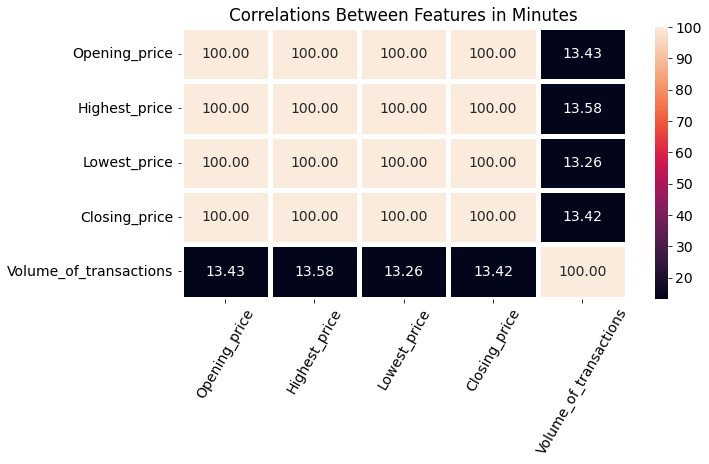

In [8]:
plot_correlation(data, title="Correlations Between Features in Minutes")

In [9]:
data_finta = pd.DataFrame()
data_finta['open'] = data['Opening_price']
data_finta['high'] = data['Highest_price']
data_finta['low'] = data['Lowest_price']
data_finta['close'] = data['Closing_price']
data_finta['volume'] = data['Volume_of_transactions']
data_min = data.copy()
extra_features = ['TRIX', 'VWAP', 'MACD', 'EV_MACD', 'MOM', 'RSI', 'IFT_RSI', 'TR', 'ATR', 'BBWIDTH', 'DMI', 'ADX', 'STOCHRSI',
                  'MI', 'CHAIKIN', 'VZO', 'PZO', 'EFI', 'EBBP', 'BASP', 'BASPN', 'WTO', 'SQZMI', 'VFI', 'STC']
both_columns_features = ["DMI", "EBBP", "BASP", "BASPN"]
add_finta_feature(data_min, data_finta, extra_features, both_columns_features)

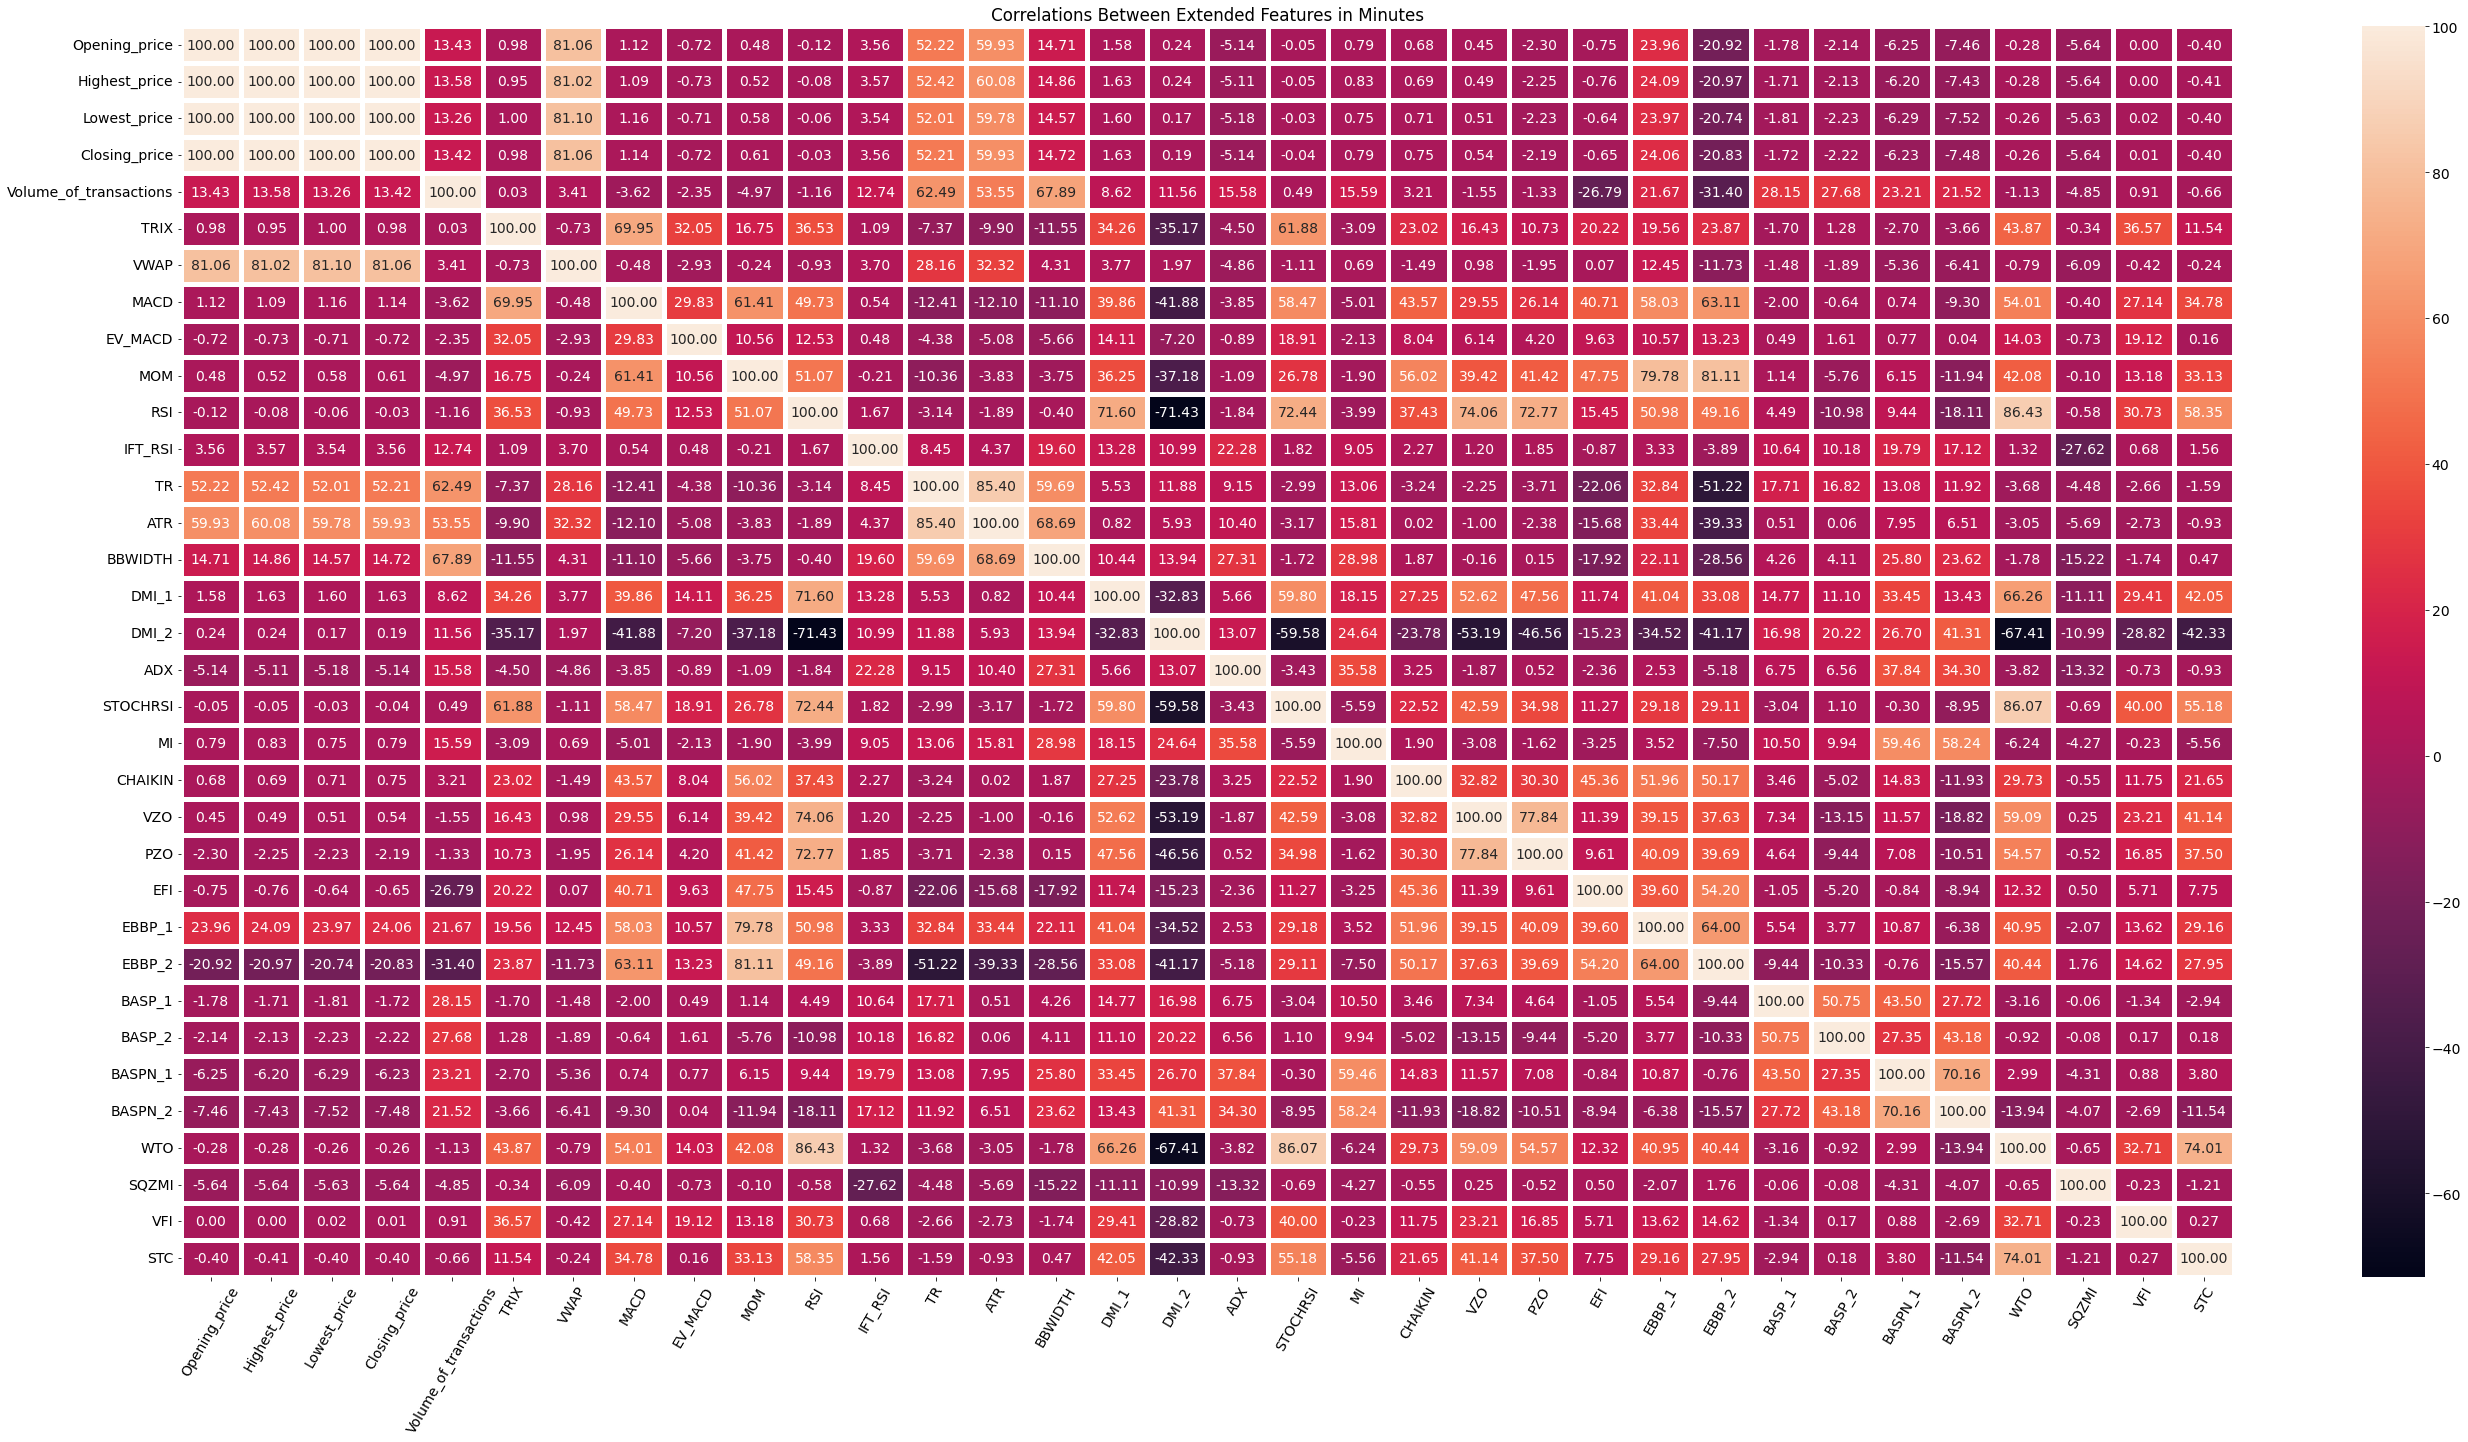

In [11]:
plot_correlation(data_min,
                     title="Correlations Between Extended Features in Minutes",
                     figsize=(46, 23))

In [12]:
max_index = -np.inf
for column in data_min.columns:
    nan_indices = data_min[column].index[data_min[column].apply(np.isnan)]
    max_index_column = np.max(nan_indices)
    if max_index_column > max_index:
        max_index = max_index_column
if plot_data_process:
    print("\nLast index containing NaN in all data:", max_index)
    start_index = max_index + 1
data_min = data_min.iloc[start_index: , :]
data_min = data_min.reset_index(drop=True)
start_hour = start_index // 60
start_minute = start_index % 60
data_min.drop(['Timestamp'], inplace=True, axis=1)

new_columns_order = ['Closing_price', 'Volume_of_transactions', 'Opening_price', 'Highest_price', 'Lowest_price','TRIX', 'VWAP', 'MACD',
                     'EV_MACD', 'MOM', 'RSI', 'IFT_RSI', 'TR', 'ATR', 'BBWIDTH', 'DMI_1', 'DMI_2', 'ADX', 'STOCHRSI', 'MI', 'CHAIKIN', 
                     'VZO', 'PZO', 'EFI', 'EBBP_1', 'EBBP_2', 'BASP_1', 'BASP_2', 'BASPN_1', 'BASPN_2', 'WTO', 'SQZMI', 'VFI', 'STC']
data_min = data_min[new_columns_order]


Last index containing NaN in all data: 130


In [14]:
pd.options.display.max_columns = data_min.shape[1]

data_min.head()

,Closing_price,Volume_of_transactions,Opening_price,Highest_price,Lowest_price,TRIX,VWAP,MACD,EV_MACD,MOM,RSI,IFT_RSI,TR,ATR,BBWIDTH,DMI_1,DMI_2,ADX,STOCHRSI,MI,CHAIKIN,VZO,PZO,EFI,EBBP_1,EBBP_2,BASP_1,BASP_2,BASPN_1,BASPN_2,WTO,SQZMI,VFI,STC
0,0.2126,30733.9,0.2122,0.2130,0.2122,0.048684,0.210120,-0.000592,0.087280,-0.0023,41.028784,0.648714,0.0008,0.001593,0.041188,14.077225,20.483995,28.831533,0.468029,22.090828,-15279.401839,-6.668066,-14.030874,-1.281607,-0.001059,-0.001859,0.273365,0.258140,0.564927,0.616766,-38.483969,False,24.742857,5.921189e-15
1,0.2125,39770.1,0.2126,0.2130,0.2125,0.040929,0.210132,-0.000663,0.087158,-0.0018,40.650070,0.647118,0.0005,0.001436,0.043015,13.070949,19.019747,28.095685,0.452405,21.920226,-27637.284543,-20.502179,-25.416545,-1.666664,-0.000836,-0.001336,0.000000,0.432263,0.511121,0.599190,-39.381238,False,24.758808,5.921189e-15
2,0.2123,24005.6,0.2125,0.2126,0.2122,0.033404,0.210138,-0.000728,0.086868,-0.0015,39.857662,0.665397,0.0004,0.001286,0.043248,12.136655,19.328076,27.721124,0.439081,21.743810,-33968.651455,-27.941139,-35.295078,-2.114444,-0.001017,-0.001417,0.061165,0.166194,0.468266,0.557943,-40.773237,False,24.514128,5.921189e-15
3,0.2122,84224.8,0.2123,0.2126,0.2122,0.026171,0.210159,-0.000778,0.085397,-0.0021,39.443643,0.687675,0.0004,0.001157,0.043530,11.269186,17.946600,27.373353,0.429519,21.633028,-60171.684392,-47.738728,-43.869282,-3.015592,-0.000814,-0.001214,0.000000,0.775886,0.423667,0.578704,-41.519406,False,24.369204,5.921189e-15
4,0.2123,12597.9,0.2123,0.2124,0.2121,0.019356,0.210162,-0.000801,0.085133,-0.0024,40.113560,0.681882,0.0003,0.000907,0.043146,10.463757,17.451802,27.206069,0.424469,21.598649,-64065.236424,-41.050580,-24.781357,-2.404823,-0.000855,-0.001155,0.070744,0.031493,0.390054,0.526579,-41.946166,False,24.182789,5.921189e-15


In [17]:
#data_min.to_parquet("XRP_1MIN_WITH_INDICATORS.parquet", index = False)

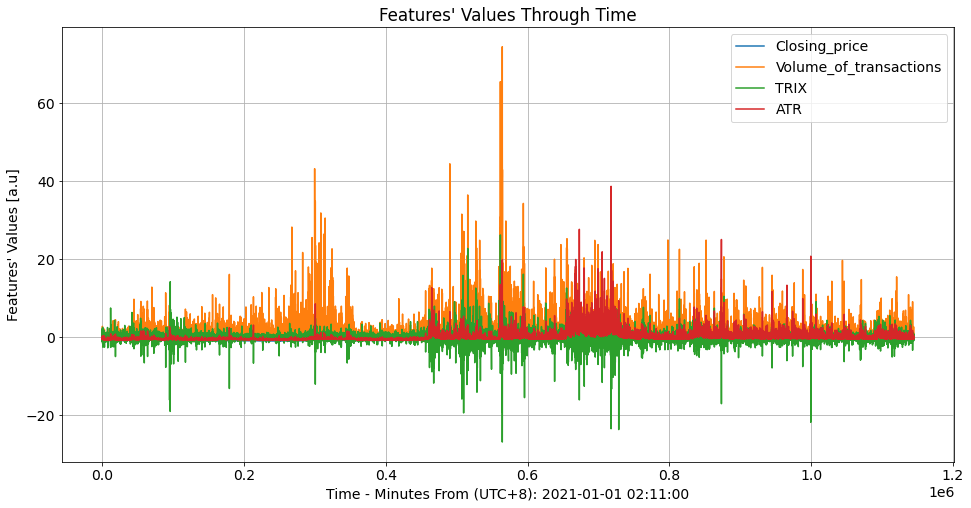

In [19]:
plot_scaled_features(data_min, 
                         features_to_plot=['Closing_price', 'Volume_of_transactions', 'TRIX', 'ATR'],
                         scaler=pp.StandardScaler(),
                         xlabel="Time - Minutes From (UTC+8): 2021-01-01 {:02d}:{:02d}:00".format(start_hour, start_minute)
                        )

In [20]:
val_percentage = 0.1
test_percentage = 0.1
train_df, val_df, test_df = train_validation_test_split(data_min, val_percentage, test_percentage)
print(np.shape(train_df))
if val_df is not None:
    print(np.shape(val_df))
print(np.shape(test_df))

(915768, 34)
(114470, 34)
(114470, 34)


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


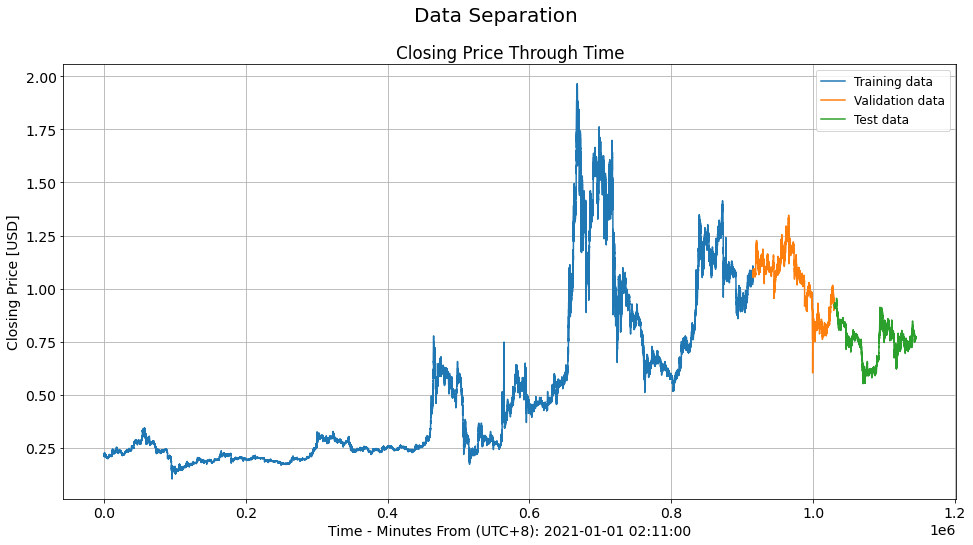

In [21]:
if plot_data_process:
    train_time = np.arange(np.size(train_df, 0))
    if val_df is not None:
        val_time = np.arange(np.size(train_df, 0), np.size(train_df, 0) + np.size(val_df, 0))
        test_time = np.arange(np.size(train_df, 0) + np.size(val_df, 0), np.size(train_df, 0) + np.size(val_df, 0) + np.size(test_df, 0))
    else:
        test_time = np.arange(np.size(train_df, 0), np.size(train_df, 0) + np.size(test_df, 0))
    fig = plt.figure(figsize=(16, 8))
    st = fig.suptitle("Data Separation", fontsize=20)
    ax = fig.add_subplot(1, 1 ,1)
    ax.set_xlabel("Time - Minutes From (UTC+8): 2021-01-01 {:02d}:{:02d}:00".format(start_hour, start_minute))     
    ax.set_ylabel("Closing Price [USD]")            
    ax.set_title("Closing Price Through Time")
    ax.plot(train_time, train_df['Closing_price'], label='Training data')
    if val_df is not None:
        ax.plot(val_time, val_df['Closing_price'], label='Validation data')
    ax.plot(test_time, test_df['Closing_price'], label='Test data')
    ax.grid()
    ax.legend(loc="best", fontsize=12) 
    plt.show()

In [22]:
predicted_feature = train_df.columns.get_loc('Closing_price')
if scaler_name == 'standard':
    scaler = pp.StandardScaler()
if scaler_name == 'minmax':
    scaler = pp.MinMaxScaler()
in_features = num_features
criterion = nn.MSELoss()

# define the model
model = BTC_Transformer(num_encoder_layers=num_encoder_layers,
                        num_decoder_layers=num_decoder_layers,
                        in_features=in_features,
                        periodic_features=periodic_features,
                        out_features=out_features,
                        nhead=nhead,
                        dim_feedforward=dim_feedforward,
                        dropout=dropout,
                        activation=activation
                       ).to(device)

# optimization
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size, gamma)

# create the relevant data
train = train_df.iloc[:, :num_features]
if val_df is not None:
    val = val_df.iloc[:, :num_features]
else:
    val = val_df
test = test_df.iloc[:, :num_features]
train, val ,test ,scaler = normalize_data(train, val ,test ,scaler)
train_data = betchify(train, train_batch_size).float()
if val is not None:
    val_data = betchify(val, eval_batch_size).float()
test_data = betchify(test, eval_batch_size).float()

In [23]:
model_stats = summary(
                model = model, 
                input_data = [(bptt_src, in_features), (bptt_tgt, in_features)], 
                dtypes = [torch.float, torch.float],
                batch_dim = 1,
                col_names = ("input_size", "output_size", "num_params"),
                device = device, 
                depth = 4, 
                verbose = 0
                )
print(str(model_stats))

Layer (type:depth-idx)                             Input Shape               Output Shape              Param #
├─SineActivation: 1-1                              [10, -1, 34]              [10, -1, 60]              --
|    └─Dropout: 2-1                                [10, -1, 60]              [10, -1, 60]              --
├─SineActivation: 1-2                              [2, -1, 34]               [2, -1, 60]               (recursive)
|    └─Dropout: 2-2                                [2, -1, 60]               [2, -1, 60]               --
├─Transformer: 1-3                                 [10, -1, 60]              [2, -1, 60]               --
|    └─TransformerEncoder: 2-3                     [10, -1, 60]              [10, -1, 60]              --
|    |    └─ModuleList: 3                          []                        []                        --
|    |    |    └─TransformerEncoderLayer: 4-1      [10, -1, 60]              [10, -1, 60]              61,404
|    |    |    └─Transformer

In [24]:
## train the model
# prepare vars to hold best model and training statistics
best_val_loss = float('inf')
best_model = None
train_loss = []
valid_loss = []

for epoch in range(1, epochs + 1):
    # epoch initialization
    epoch_start_time = time.time()
    model.train()
    total_loss = 0.
    epoch_loss = 0.
    start_time = time.time()
    
    # start point of the data
    if random_start_point:
        start_point = np.random.randint(bptt_src)
    else:
        start_point = 0
    
    num_batches = (len(train_data) - start_point) // bptt_src
    log_interval = round(num_batches // 3 / 10) * 10
    
    # masks for the model 
    src_mask = torch.zeros((bptt_src,bptt_src), dtype=torch.bool).to(device) # zeros mask for the source (no mask)
    tgt_mask = model.transformer.generate_square_subsequent_mask(bptt_tgt).to(device) # look-ahead mask for the target
    

    for batch, i in enumerate(range(start_point, train_data.size(0) - 1, bptt_src)):
        # forward
        source, targets = get_batch(train_data, i, bptt_src, bptt_tgt, overlap)
        src_batch_size = source.size(0)
        tgt_batch_size = targets.size(0)
        if tgt_batch_size != bptt_tgt or src_batch_size != bptt_src:  # only on last batch
            src_mask = src_mask[:src_batch_size, :src_batch_size]
            tgt_mask = tgt_mask[:tgt_batch_size, :tgt_batch_size]
        output = model(source, targets, src_mask, tgt_mask)
        loss = criterion(output[:-1,:,predicted_feature], targets[1:,:,predicted_feature])
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_param)
        
        # step
        optimizer.step()
        
        # record bacth statistics
        total_loss += loss.item()
        epoch_loss += len(source) * loss.item()

        # print statistics every log_interval
        if (batch % log_interval == 0) and batch > 0:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            print(f'| epoch {epoch:3d} | {batch:5d}/{num_batches:5d} batches | '
                  f'lr {lr:02.6f} | ms/batch {ms_per_batch:5.2f} | '
                  f'loss {cur_loss:5.6f} ')
            total_loss = 0
            start_time = time.time()
    
    # record epoch statistics
    train_loss.append(epoch_loss / (len(train_data) - 1))
    
    # evaluate on validation and save best model
    if val is not None:
        val_loss = evaluate(model, val_data, bptt_src, bptt_tgt, overlap, criterion, predicted_feature)
        elapsed = time.time() - epoch_start_time
        print('-' * 77)
        print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
             f'valid loss {val_loss:5.6f} ')
        print('-' * 77)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model)
            
        valid_loss.append(np.mean(val_loss))

    # scheduler step
    scheduler.step()
              
if val is None:
    best_model = copy.deepcopy(model)

| epoch   1 |   950/ 2861 batches | lr 0.500000 | ms/batch 80.09 | loss 0.135669 
| epoch   1 |  1900/ 2861 batches | lr 0.500000 | ms/batch 166.48 | loss 0.000627 
| epoch   1 |  2850/ 2861 batches | lr 0.500000 | ms/batch 93.46 | loss 0.000346 
-----------------------------------------------------------------------------
| end of epoch   1 | time: 333.40s | valid loss 0.000981 
-----------------------------------------------------------------------------
| epoch   2 |   950/ 2861 batches | lr 0.475000 | ms/batch 72.45 | loss 0.000297 
| epoch   2 |  1900/ 2861 batches | lr 0.475000 | ms/batch 72.05 | loss 0.000214 
| epoch   2 |  2850/ 2861 batches | lr 0.475000 | ms/batch 75.12 | loss 0.000140 
-----------------------------------------------------------------------------
| end of epoch   2 | time: 218.93s | valid loss 0.000375 
-----------------------------------------------------------------------------
| epoch   3 |   950/ 2861 batches | lr 0.451250 | ms/batch 71.45 | loss 0.00014

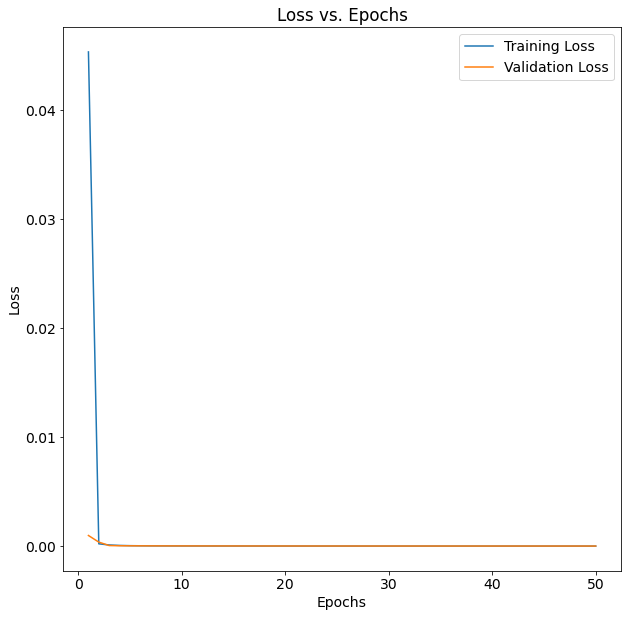

In [25]:
# plot loss functions
epochs_list = np.arange(1,epochs + 1)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.set_title("Loss vs. Epochs")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.plot(epochs_list, train_loss, label='Training Loss')
if val is not None:
    ax.plot(epochs_list, valid_loss, label='Validation Loss')
ax.legend() 
plt.show()

#### Model training looks strongly broken

In [26]:
# calculate test loss
test_loss = evaluate(best_model, test_data, bptt_src, bptt_tgt, overlap, criterion, predicted_feature)
test_ppl = math.exp(test_loss)
print('-' * 77)
print(f'test loss {test_loss:5.6f}')
print('-' * 77)

-----------------------------------------------------------------------------
test loss 0.000014
-----------------------------------------------------------------------------


In [27]:
best_model

BTC_Transformer(
  (sine_activation): SineActivation(
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=60, out_features=60, bias=True)
          )
          (linear1): Linear(in_features=60, out_features=384, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (linear2): Linear(in_features=384, out_features=60, bias=True)
          (norm1): LayerNorm((60,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((60,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.0, inplace=False)
          (dropout2): Dropout(p=0.0, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=60, out_features=60, bias=True)
       

In [32]:
MODELPATH = "TSMODELS/xrp_finta_model"
torch.save(best_model, MODELPATH)

mymodel = torch.load(MODELPATH)
mymodel.eval()

BTC_Transformer(
  (sine_activation): SineActivation(
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=60, out_features=60, bias=True)
          )
          (linear1): Linear(in_features=60, out_features=384, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (linear2): Linear(in_features=384, out_features=60, bias=True)
          (norm1): LayerNorm((60,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((60,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.0, inplace=False)
          (dropout2): Dropout(p=0.0, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=60, out_features=60, bias=True)
       

### Inference

In [80]:
def evaluate(model, data, bptt_src, bptt_tgt, overlap, criterion, predicted_feature):
    """run the data through the model in eval mode and calculate the average loss in the given feature
    
    Args:
        model: nn.Module, the model you want to run the data in
        data: Tensor, shape [N, batch_size, E]
        bptt_src: int, size of back propagation through time, sequence length of source
        bptt_tgt: int, size of back propagation through time, sequence length of target
        overlap: int, number of overlapping elements between source and target
        criterion: nn.module, the loss function
        predicted_feature: int, index of the feature you want to evaluate in [0,E-1]
        

    Returns:
        mean_loss: float, average loss recieved over all data on the chosen feature
    """
    real = []
    pred = []
    model.eval()     # Turn on the evaluation mode
    total_loss = 0.
    src_mask = torch.zeros((bptt_src,bptt_src), dtype=torch.bool).to(device) # zeros mask for the source (no mask)
    tgt_mask = model.transformer.generate_square_subsequent_mask(bptt_tgt).to(device) # look-ahead mask for the target
    with torch.no_grad():
        for i in range(0, data.size(0) - 1, bptt_src):
            source, targets = get_batch(data, i, bptt_src, bptt_tgt, overlap)
            src_batch_size = source.size(0)
            tgt_batch_size = targets.size(0)
            if tgt_batch_size != bptt_tgt or src_batch_size != bptt_src:  # only on last batch
                src_mask = src_mask[:src_batch_size, :src_batch_size]
                tgt_mask = tgt_mask[:tgt_batch_size, :tgt_batch_size]    
            output = model(source, targets, src_mask, tgt_mask)
            pred.append(output[:-1,:,predicted_feature])
            real.append(targets[1:,:,predicted_feature])
            loss = criterion(output[:-1,:,predicted_feature], targets[1:,:,predicted_feature])
            total_loss += len(source) * loss.item()
    mean_loss = total_loss / (len(data) - 1)
    return mean_loss, real, pred

In [81]:
# calculate test loss
test_loss, real, pred = evaluate(mymodel, test_data, bptt_src, bptt_tgt, overlap, criterion, predicted_feature)
test_ppl = math.exp(test_loss)
print('-' * 77)
print(f'test loss {test_loss:5.6f}')
print('-' * 77)

-----------------------------------------------------------------------------
test loss 0.000014
-----------------------------------------------------------------------------


In [85]:
def test_data_index(index, real, pred):
    pd.DataFrame(data = {"real":real[index][0], "pred":pred[index][0]}).plot(figsize = (15, 7))

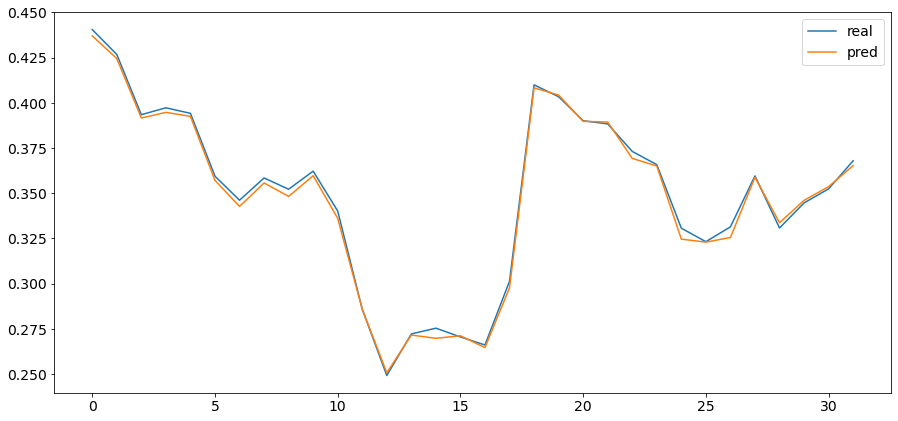

In [86]:
test_data_index(0, real, pred)

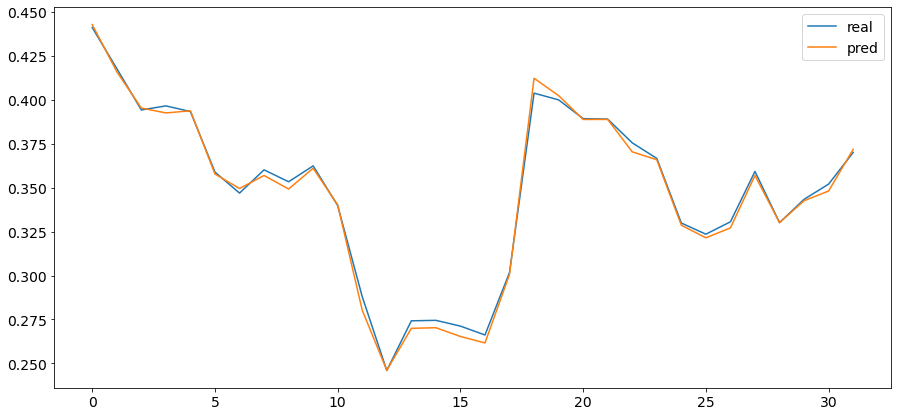

In [87]:
test_data_index(1, real, pred)

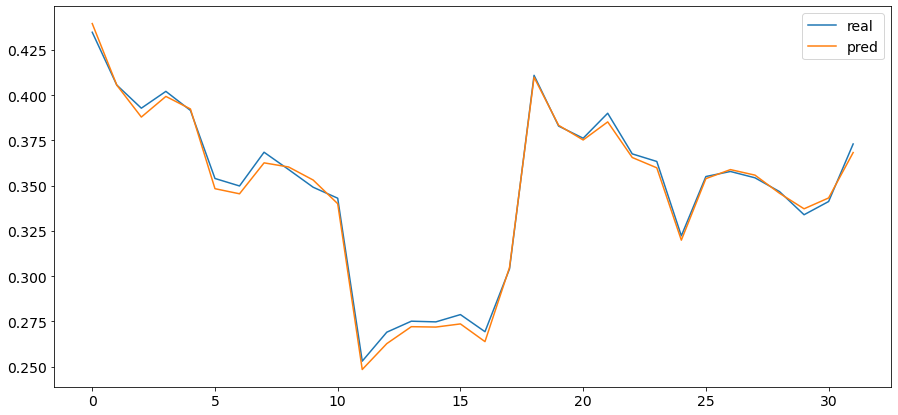

In [88]:
test_data_index(100, real, pred)

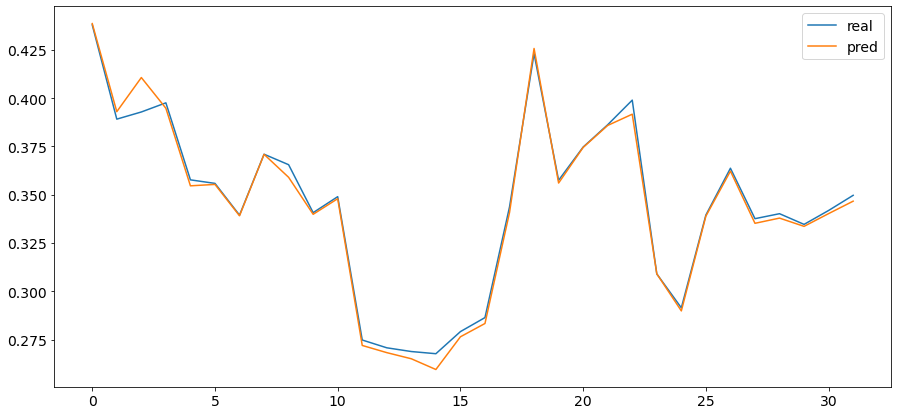

In [89]:
test_data_index(200, real, pred)

In [91]:
def get_test_data():
    data = pd.read_csv("Binance_XRPUSDT_minute (1).csv", skiprows = 1)[::-1].reset_index(drop = True)
    data = data.drop(['date', 'symbol', 'Volume USDT', 'tradecount'], axis = 1 )
    columns_dict = {'unix': 'Unix_timestamp',
                    'open': 'Opening_price',
                    'high': 'Highest_price',
                    'low': 'Lowest_price',
                    'close': 'Closing_price',
                    'Volume XRP': 'Volume_of_transactions'
                   }
    data = data.rename(columns=columns_dict)
    data = data.sort_values('Unix_timestamp', ignore_index=True)
    data['Unix_timestamp'] = pd.to_datetime(data['Unix_timestamp'], unit='ms') + pd.Timedelta('08:00:00')
    data = data.rename(columns={'Unix_timestamp': 'Timestamp'})
    
    data_finta = pd.DataFrame()
    data_finta['open'] = data['Opening_price']
    data_finta['high'] = data['Highest_price']
    data_finta['low'] = data['Lowest_price']
    data_finta['close'] = data['Closing_price']
    data_finta['volume'] = data['Volume_of_transactions']
    data_min = data.copy()
    extra_features = ['TRIX', 'VWAP', 'MACD', 'EV_MACD', 'MOM', 'RSI', 'IFT_RSI', 'TR', 'ATR', 'BBWIDTH', 'DMI', 'ADX', 'STOCHRSI',
                      'MI', 'CHAIKIN', 'VZO', 'PZO', 'EFI', 'EBBP', 'BASP', 'BASPN', 'WTO', 'SQZMI', 'VFI', 'STC']
    both_columns_features = ["DMI", "EBBP", "BASP", "BASPN"]
    add_finta_feature(data_min, data_finta, extra_features, both_columns_features)
    
    max_index = -np.inf
    for column in data_min.columns:
        nan_indices = data_min[column].index[data_min[column].apply(np.isnan)]
        max_index_column = np.max(nan_indices)
        if max_index_column > max_index:
            max_index = max_index_column
    if plot_data_process:
        print("\nLast index containing NaN in all data:", max_index)
        start_index = max_index + 1
    data_min = data_min.iloc[start_index: , :]
    data_min = data_min.reset_index(drop=True)
    start_hour = start_index // 60
    start_minute = start_index % 60
    data_min.drop(['Timestamp'], inplace=True, axis=1)

    new_columns_order = ['Closing_price', 'Volume_of_transactions', 'Opening_price', 'Highest_price', 'Lowest_price','TRIX', 'VWAP', 'MACD',
                         'EV_MACD', 'MOM', 'RSI', 'IFT_RSI', 'TR', 'ATR', 'BBWIDTH', 'DMI_1', 'DMI_2', 'ADX', 'STOCHRSI', 'MI', 'CHAIKIN', 
                         'VZO', 'PZO', 'EFI', 'EBBP_1', 'EBBP_2', 'BASP_1', 'BASP_2', 'BASPN_1', 'BASPN_2', 'WTO', 'SQZMI', 'VFI', 'STC']
    data_min = data_min[new_columns_order]
    
    return data_min

In [111]:
tempdf = pd.read_csv("Binance_XRPUSDT_minute (1).csv", skiprows = 1, parse_dates = ["date"])[::-1].reset_index(drop = True)

In [116]:
data = pd.read_csv("Binance_XRPUSDT_minute (1).csv", skiprows = 1)[::-1].reset_index(drop = True)
data = data.drop(['date', 'symbol', 'Volume USDT', 'tradecount'], axis = 1 )
columns_dict = {'unix': 'Unix_timestamp',
                'open': 'Opening_price',
                'high': 'Highest_price',
                'low': 'Lowest_price',
                'close': 'Closing_price',
                'Volume XRP': 'Volume_of_transactions'
               }
data = data.rename(columns=columns_dict)
data = data.sort_values('Unix_timestamp', ignore_index=True)
data['Unix_timestamp'] = pd.to_datetime(data['Unix_timestamp'], unit='ms') + pd.Timedelta('08:00:00')
data = data.rename(columns={'Unix_timestamp': 'Timestamp'})
data

,Timestamp,Opening_price,Highest_price,Lowest_price,Closing_price,Volume_of_transactions
0,2020-01-06 16:21:00,0.1970,0.1970,0.1970,0.1970,6111.6
1,2020-01-06 16:22:00,0.1970,0.1970,0.1970,0.1970,0.0
2,2020-01-06 16:23:00,0.1970,0.1970,0.1970,0.1970,0.0
3,2020-01-06 16:24:00,0.1970,0.1970,0.1970,0.1970,0.0
4,2020-01-06 16:25:00,0.1970,0.1970,0.1970,0.1970,0.0
...,...,...,...,...,...,...
1144834,2022-03-15 11:03:00,0.7674,0.7675,0.7670,0.7672,102589.0
1144835,2022-03-15 11:04:00,0.7671,0.7671,0.7658,0.7662,169177.0
1144836,2022-03-15 11:05:00,0.7662,0.7662,0.7658,0.7660,66867.0
1144837,2022-03-15 11:06:00,0.7661,0.7667,0.7661,0.7664,46975.0


### Need more data to test inference